/usr/local/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /root/code/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /root/code/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /root/code/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /root/code/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
INFO:tensorflow:Restoring parameters from /tmp/tf_cnn2/model.ckpt


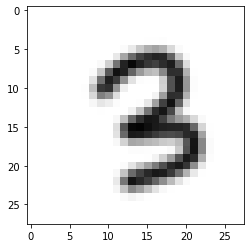

识别结果:
3


In [1]:
from PIL import Image, ImageFilter

import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data


import tensorflow as tf
from datetime import datetime
mnist = input_data.read_data_sets('/root/code/MNIST_data/', one_hot=True) 
#MNIST数据集所在路径

x = tf.placeholder(tf.float32, [None, 784])

y_ = tf.placeholder(tf.float32, [None, 10])
lr = tf.Variable(0.001,dtype=tf.float32)

def weight_variable(shape):
    initial = tf.truncated_normal(shape,stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1,shape = shape)
    return tf.Variable(initial)

def conv2d(x,W):
    return tf.nn.conv2d(x, W, strides = [1,1,1,1], padding = 'SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x,[-1,28,28,1])

h_conv1 = tf.nn.relu(conv2d(x_image,W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


#写预测接口 一串函数写进去？
# predition_L = tf.argmax(tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2),1)
prediction=tf.argmax(y_conv,1)




saver = tf.train.Saver()
sess = tf.Session()

sess.run(tf.global_variables_initializer())
saver.restore(sess, '/tmp/tf_cnn2/model.ckpt') #使用模型，参数和之前的代码保持一致

prediction=tf.argmax(y_conv,1)
im = Image.open('/root/code/pic_png/3.png') #读取的图片所在路径，注意是28*28像素
plt.imshow(im)  #显示需要识别的图片
plt.show()
im = im.convert('L')
tv = list(im.getdata()) 
tva = [(255-x)*1.0/255.0 for x in tv] 
predint=prediction.eval(feed_dict={x: [tva],keep_prob: 1.0}, session=sess)
#TypeError: eval() got an unexpected keyword argument 'name' 这是不是代表 sess.run的函数方式行不通了
print('识别结果:')
print(predint[0])
#用了函数处理 图像数据 所以用x:【result】

In [2]:
def predict10(sess, adds):
    import json
    num_imgs = len(adds)
    result = []
    for i in range(num_imgs):
        data = json.loads(adds[i])
        predints=sess.run('y_conv:0',feed_dict={"x:0":data,"keep_prob:0": 1.0})
        result.append(str(predints[0]))
    
    return result

In [3]:
from clipper_admin import ClipperConnection, DockerContainerManager
from clipper_admin.deployers.tensorflow import deploy_tensorflow_model
clipper_conn = ClipperConnection(DockerContainerManager())

In [4]:
clipper_conn.start_clipper()

20-07-16:05:21:47 INFO     [docker_container_manager.py:184] [default-cluster] Starting managed Redis instance in Docker
20-07-16:05:21:52 INFO     [docker_container_manager.py:276] [default-cluster] Metric Configuration Saved at /tmp/tmpr_8eqijq.yml
20-07-16:05:21:53 INFO     [clipper_admin.py:162] [default-cluster] Clipper is running


In [5]:
clipper_conn.connect()

20-07-16:05:21:54 INFO     [clipper_admin.py:172] [default-cluster] Successfully connected to Clipper cluster at localhost:1337


In [6]:
clipper_conn.register_application(
    name="mnist-app", input_type="strings", default_output="-1.0", slo_micros=100000)

20-07-16:05:21:56 INFO     [clipper_admin.py:236] [default-cluster] Application mnist-app was successfully registered


In [7]:
deploy_tensorflow_model(
    clipper_conn,
    name="mnist-mod",
    version=1, # version 2 of the same model, `predict` endpoint will be updated 
    # automatically to the newest model version
    input_type="strings",
     func=predict10,
    tf_sess_or_saved_model_path=sess,
   )

20-07-16:05:21:58 INFO     [deployer_utils.py:41] Saving function to /tmp/tmpz2louyiaclipper
20-07-16:05:21:58 INFO     [deployer_utils.py:51] Serialized and supplied predict function
20-07-16:05:21:58 INFO     [tensorflow.py:196] TensorFlow model saved at: /tmp/tmpz2louyiaclipper/tfmodel/model.ckpt 
20-07-16:05:21:58 INFO     [tensorflow.py:277] Using Python 3.6 base image
20-07-16:05:21:58 INFO     [clipper_admin.py:534] [default-cluster] Building model Docker image with model data from /tmp/tmpz2louyiaclipper
20-07-16:05:22:00 INFO     [clipper_admin.py:539] [default-cluster] Step 1/2 : FROM clipper/tf36-container:0.4.1
20-07-16:05:22:00 INFO     [clipper_admin.py:539] [default-cluster]  ---> 3db42af800ff
20-07-16:05:22:00 INFO     [clipper_admin.py:539] [default-cluster] Step 2/2 : COPY /tmp/tmpz2louyiaclipper /model/
20-07-16:05:22:00 INFO     [clipper_admin.py:539] [default-cluster]  ---> 3743c9d9d1bf
20-07-16:05:22:00 INFO     [clipper_admin.py:539] [default-cluster] Successfull

In [8]:
clipper_conn.link_model_to_app(
    app_name="mnist-app",
    model_name="mnist-mod")

20-07-16:05:22:13 INFO     [clipper_admin.py:303] [default-cluster] Model mnist-mod is now linked to application mnist-app


In [9]:
# Get query address
query_address = clipper_conn.get_query_addr()
print(query_address)

localhost:1337


In [15]:
import matplotlib.pyplot as plt
import base64
import json
import requests
from datetime import datetime



def query_json(addr, filename,mnist,sess):
    url = "http://%s/mnist-app/predict" % addr

    im = Image.open(filename)
    plt.imshow(im)  #显示需要识别的图片
    plt.show()
    im = im.convert('L')
    tv = list(im.getdata())
    tva = [[(255-x)*1.0/255.0 for x in tv]]
    tva = json.dumps(tva)
    tva_j = json.dumps({"input": tva})
    headers = {'Content-type': 'application/json'}
    start = datetime.now()
    r = requests.post(url, headers=headers, data=tva_j)
    end = datetime.now()
    latency = (end - start).total_seconds() * 1000.0
    print(latency)
    re = r.text
    global false, null, true

    false = null = true = ''
    ls = eval(re)
    numbers = ls['output']
    numbers_str = numbers[1:-1]
    numbers_str=numbers_str.replace("\n", "")
    list1 = numbers_str.split(' ')
    print("this number is "+ str(list1.index(max(list1)))+" , "+"The latency is   "+str(latency))
    print('test accuracy %g' % accuracy.eval(feed_dict={
        "x:0": mnist.test.images, "y_:0": mnist.test.labels, keep_prob: 1.0},session=sess))
    return (list1.index(max(list1)))

Extracting /root/code/MNIST_data/train-images-idx3-ubyte.gz
Extracting /root/code/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /root/code/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /root/code/MNIST_data/t10k-labels-idx1-ubyte.gz


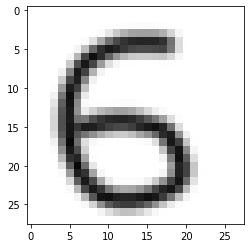

5.933


TypeError: 'float' object is not subscriptable

In [18]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/root/code/MNIST_data/', one_hot=True) 
query_json(query_address, "/root/code/pic_png/6.png",mnist,sess)

In [19]:
clipper_conn.stop_all()

20-07-16:05:25:27 INFO     [clipper_admin.py:1424] [default-cluster] Stopped all Clipper cluster and all model containers
